# Predicting excess returns with the information content of options prices

## Theory
Asset pricing theory suggests that expected returns and risk-neutral variance are linked via 
$$ E_t R_T - R_{f,t} = \frac{1}{R_{f,t}} var_t R_T - cov_t(M_TR_T, R_T).$$
If $cov_t(M_TR_T, R_T) \leq 0$ the risk neutral variance acts as a lower bound on expected returns and empirical measure of this variance should have preditive power in forecasting excess returns. This code uses the Black-Scholes formula extract a call-implied risk neutral variance and a put-implied risk-neutral variance and tests the predicctive power of information content in option prices. 

Black-Scholes has notable failures--primarily that implied volatilities are not flat across the strike space. However, that doesn't mean that we can't use it to recover a measure of $var_t$. Recall that the Black-Scholes formula is given by the following parameters:

- $ S_0 $: Current price of the underlying asset
- $ K $: Strike price of the option
- $ r $: Risk-free interest rate (annualized)
- $ T $: Time to expiration (in years)
- $ \sigma $: Volatility of the underlying asset

### Call Option Price ($ C $)

The price of a European call option is calculated as:

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

### Put Option Price ($ P $)

The price of a European put option is calculated as:
$$
P = K e^{-rT} N(-d_2) - S_0 N(-d_1)
$$

### Where:

$$
d_1 = \frac{\ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

### And:

- $ N(\cdot) $ is the cumulative distribution function of the standard normal distribution.
- $ e $ is the base of the natural logarithm.
- $ \ln $ is the natural logarithm.

Denote $P^{obs}_t(K)$ as the observed price of an option and $P^{BS}_t(K)$ as the Black-Scholes implied price of an option given a set of parameters from above. A natural measure of the risk-neutral variance would be $\sigma^2$. Hence, for a given day we could solve for a $\hat{\sigma}$ that solves the following problem 
$$
  \min_\sigma \sum_{k\in K}\left(\frac{(P^{obs}_t(K)-P^{BS}_t(K))^2}{K}\right).
$$
We know that a log-normal distribution fails to fully capture the variation in options prices on a given day, but we can still test if it is a noisy measure of the risk-variance of the true distribution that generates option prices. To give ourselves slightly more flexibility, we can allow a different volatility of puts and calls and solve the problem 
$$
  \min_{\sigma_C, \sigma_P} \sum_{k\in K}\left(\frac{(P^{obs}_t(K)-P^{BS}_t(K))^2}{K}\right).
$$
and have a put and call implied volatility. The theory above suggests that, if these are proxies for the true risk-netural variance, they can be used to forecast excess returns in linear regressions of the form $$\frac{1}{T-t} (R_T - R_{f,t}) = \alpha + \mathbf{\beta} \mathbf{X}_t +\varepsilon_T$$
where $\mathbf{X}_t$ is potentially a scalar or vector of explanatory variables. We first test $\sigma_C$ and $\sigma_P$ separately and then compute the results of including both as explanatory variables. The null hypothesis of the theory above is that $\alpha = 0$ and $\beta = 1$. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.special import erf, erfc
from scipy.optimize import brute
from mpl_toolkits.mplot3d import Axes3D
from concurrent.futures import ThreadPoolExecutor
from pandas.plotting import register_matplotlib_converters
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output
import time
register_matplotlib_converters()

In [2]:
def black_scholes_option_price(S0, K, r, T, sigma_C, sigma_P, option_type='C'):
    """
    Calculate the Black-Scholes option price for a call or put option.
    
    Parameters:
    - S0: Current price of the underlying asset
    - K: Strike price of the option
    - r: Risk-free interest rate (annualized)
    - T: Time to expiration (in years)
    - sigma: Volatility of the underlying asset
    - option_type: 'C' for call option, 'P' for put option

    Returns:
    - Option price calculated using the Black-Scholes formula
    """
    
    # Determine which volatility to use based on option type
    sigma = sigma_C if option_type == 'C' else sigma_P
    
    # Calculate d1 and d2 parameters
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate call or put option price
    if option_type == 'C':
        option_price = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'P':
        option_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1))
    else:
        raise ValueError("Invalid option type. Use 'C' for call or 'P' for put.")

    return option_price

# Define the compute_implied_sharpe_for_date_global function
def compute_implied_sharpe_for_date_global(chosen_date, options, underlying, risk_free_rate):    # Extract relevant data for the chosen date
    underlying_price = underlying[underlying['date'] == chosen_date]['close'].values[0]
    options_subset = options[options['date'] == chosen_date]
    time_to_expiration = options_subset['tau'].unique()
    closest_expiration = min([tau for tau in time_to_expiration if tau > 30])
    options_closest_expiration = options_subset[options_subset['tau'] == closest_expiration]

    # Subset to OTM options
    otm_calls = options_closest_expiration[(options_closest_expiration['cp_flag'] == 'C') & 
                                           (options_closest_expiration['strike_price']/1000 > underlying_price)]
    otm_puts = options_closest_expiration[(options_closest_expiration['cp_flag'] == 'P') & 
                                          (options_closest_expiration['strike_price']/1000 < underlying_price)]
    call_strikes = otm_calls['strike_price'].values / 1000
    put_strikes = otm_puts['strike_price'].values / 1000

    # Define the observed option prices and types
    observed_prices_calls = (otm_calls['best_bid'] + otm_calls['best_offer']) / 2
    observed_prices_puts = (otm_puts['best_bid'] + otm_puts['best_offer']) / 2
    observed_prices = np.concatenate([observed_prices_calls.values, observed_prices_puts.values])
    observed_strikes = np.concatenate([call_strikes, put_strikes])
    observed_types = ['C' if K > underlying_price else 'P' for K in observed_strikes]

    # Construct the risk-free rate for the chosen expiration using interpolation
    risk_free_rates_subset = risk_free_rate[risk_free_rate['date'] == chosen_date]
    interp_function = interp1d(risk_free_rates_subset['days'], risk_free_rates_subset['rate'], kind='linear', fill_value="extrapolate")
    risk_free_for_expiration = float(interp_function(closest_expiration))

    # Define bounds for mu, sigma_C (for calls), and sigma_P (for puts)
    bounds = [(0.01, 0.6), (0.01, 0.9)]

    # Perform differential evolution global optimization
    daily_args = (observed_strikes, observed_prices, underlying_price, risk_free_for_expiration, closest_expiration, observed_types)
    result = differential_evolution(loss_function, bounds, args=daily_args)

    best_sigma_C, best_sigma_P = result.x  # Optimized parameters
    err = result.fun  

    # Compute the average of the two sigmas for the Sharpe ratio
    sigma_avg = (best_sigma_C + best_sigma_P) / 2

    # Compute the implied Sharpe ratio    
    results = {
        'best_sigma_C': best_sigma_C,
        'best_sigma_P': best_sigma_P,
        'sigma_avg': sigma_avg,
        'err': err,
        'observed_prices_calls': observed_prices_calls,  # Add this line
        'observed_prices_puts': observed_prices_puts,    # Add this line
        'call_strikes': call_strikes,                    # Add this line
        'put_strikes': put_strikes,                      # Add this line
        'observed_strikes': observed_strikes,            # Add this line
        'observed_types': observed_types,                # Add this line
        'closest_expiration': closest_expiration,        # Existing line
        'risk_free_for_expiration': risk_free_for_expiration,
        'underlying_price': underlying_price
    }
        
    return results

# Define the loss function
def loss_function(params, observed_strikes, observed_prices, underlying_price, risk_free_for_expiration, closest_expiration, observed_types):
    sigma_C, sigma_P = params
    theoretical_prices = [black_scholes_option_price(underlying_price, K, risk_free_for_expiration/100, 
                                                     closest_expiration/365, sigma_C, sigma_P, option_type=otype) 
                          for K, otype in zip(observed_strikes, observed_types)]
    theoretical_prices_array = np.array(theoretical_prices)
    if np.any(theoretical_prices_array <= 0):
        return 1e10  # return a large penalty if prices are non-physical
    residuals = (observed_prices - theoretical_prices_array) / observed_prices
    return np.sum(residuals**2)


def compute_implied_sharpe_dataframe(options, underlying, risk_free_rate):
    # Get unique dates from the datasets
    unique_dates = sorted(list(set(options['date'].unique()) & set(underlying['date'].unique()) & set(risk_free_rate['date'].unique())))
    
    # Lists to store results
    dates_list = []
    SD_C_list = []
    SD_P_list = []
    
    # Total number of dates for progress tracking
    total_dates = len(unique_dates)
    
    # Iterate through each date
    for i, chosen_date in enumerate(unique_dates):
        # Compute results for the date
        results = compute_implied_sharpe_for_date_global(chosen_date, options, underlying, risk_free_rate)
        
        # Accessing elements from the results dictionary
        best_sigma_C = results['best_sigma_C']
        best_sigma_P = results['best_sigma_P']
        err = results['err']
        observed_prices_calls = results['observed_prices_calls']
        observed_prices_puts = results['observed_prices_puts']
        observed_strikes = results['observed_strikes']
        observed_types = results['observed_types']
        risk_free_for_expiration = results['risk_free_for_expiration']
        underlying_price = results['underlying_price']
        put_strikes = results['put_strikes']
        call_strikes = results['call_strikes']
        
        # Append results to lists
        dates_list.append(chosen_date)
        SD_C_list.append(best_sigma_C)
        SD_P_list.append(best_sigma_P)
        
        # Print progress
        print(f"Sigma C: {best_sigma_C}  |Sigma P: {best_sigma_P} | Processed {i+1}/{total_dates} dates...", end='\r')
      

    
    # Create a dataframe from the results
    result_df = pd.DataFrame({
        'Date': dates_list,
        'sigma_C': sigma_C,
        'sigma_P': sigma_P
    })
    
    return result_df

def subset_dataframe_by_date(df, start_date, end_date, date_column='date'):
    """
    Subset a dataframe by a date range.

    Parameters:
    - df: The dataframe to subset.
    - start_date: The start of the date range (inclusive).
    - end_date: The end of the date range (inclusive).
    - date_column: The name of the date column in the dataframe. Default is 'date'.

    Returns:
    - A subsetted dataframe.
    """
    mask = (df[date_column] >= start_date) & (df[date_column] <= end_date)
    return df[mask]

def plot_option_prices(dates, options, underlying, risk_free_rate):
    # Pre-compute the results for all dates to avoid redundant computation
    precomputed_results = {date: compute_implied_sharpe_for_date_global(date, options, underlying, risk_free_rate) for date in dates}

    fig, axes = plt.subplots(1, len(dates), figsize=(14 * len(dates), 7))
    if len(dates) == 1:
        axes = [axes]
    
    for idx, chosen_date in enumerate(dates):
        # Retrieve precomputed results for the chosen date
        results = precomputed_results[chosen_date]
        plot_prices_for_date(axes[idx], chosen_date, results)

    plt.tight_layout()
    plt.show()


    
def plot_prices_for_date(ax, chosen_date, results):
    observed_prices_calls = results['observed_prices_calls']
    observed_prices_puts = results['observed_prices_puts']
    observed_strikes = results['observed_strikes']
    observed_types = results['observed_types']
    call_strikes = results['call_strikes']
    put_strikes = results['put_strikes']
    sigma_C = results['best_sigma_C']
    sigma_P = results['best_sigma_P']
    risk_free_for_expiration = results['risk_free_for_expiration']
    underlying_price = results['underlying_price']

    # Compute theoretical option prices using the optimized parameters
    theoretical_prices_optimized = [black_scholes_option_price(underlying_price, K, risk_free_for_expiration/100, 
                                                              results['closest_expiration']/365, sigma_C, sigma_P, option_type=otype) 
                                   for K, otype in zip(observed_strikes, observed_types)]

    # Plot observed OTM call options in blue and put options in red
    ax.scatter(call_strikes, observed_prices_calls, color='blue', label='Observed Call Prices', alpha=0.6)
    ax.scatter(put_strikes, observed_prices_puts, color='red', label='Observed Put Prices', alpha=0.6)

    # Plot theoretical prices using optimized parameters
    ax.scatter(observed_strikes, theoretical_prices_optimized, color='green', marker='x', label='Theoretical Prices (Optimized Parameters)')

    ax.axvline(x=underlying_price, color='black', linestyle='--', label=f'Underlying Price: {underlying_price:.2f}')
    ax.set_title(f'Option Prices vs. Strike Prices on {chosen_date}\nOptimized Sigma (σ_C): {sigma_C:.4f}, Optimized Sigma (σ_P): {sigma_P:.4f}')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Option Price')
    ax.legend()
    ax.grid(True)

def compute_all_dates(options, underlying, risk_free_rate, nworkers):
    # Get unique dates from the datasets
    unique_dates = sorted(list(set(options['date'].unique()) & set(underlying['date'].unique()) & set(risk_free_rate['date'].unique())))

    # Function to execute for each date
    def process_date(chosen_date):
        results = compute_implied_sharpe_for_date_global(chosen_date, options, underlying, risk_free_rate)
        return {
            'Date': chosen_date,
            'Optimized_sigma_C': results['best_sigma_C'],
            'Optimized_sigma_P': results['best_sigma_P'],
            'Loss_Error': results['err']
        }

    # Use ThreadPoolExecutor to parallelize the computation
    display(f"Starting parallel workers: {nworkers}")
    results_list = []
    with ThreadPoolExecutor(max_workers=nworkers) as executor:  # Adjust the number of workers as needed
        # Submit all the tasks and get their futures
        progress=0
        future_to_date = {executor.submit(process_date, date): date for date in unique_dates}
        for future in as_completed(future_to_date):
            date = future_to_date[future]
            try:
                result = future.result()
                results_list.append(result)
                progress += 1
                clear_output(wait=True)
                display(f"Completed {progress*100/len(unique_dates):.2f}% - {result}")
            except Exception as exc:
                display(f"Date {date} generated an exception: {exc}")

    # Create a dataframe from the results
    result_df = pd.DataFrame(results_list)
    
    # Sort the dataframe by date
    result_df.sort_values('Date', inplace=True)
    
    return result_df

def plot_results(result_df):
    # Set the figure size and layout
    plt.figure(figsize=(14, 10))
    result_df['Date'] = pd.to_datetime(result_df['Date'])

    
    # Plot optimized sigma
    plt.subplot(3, 1, 1)
    plt.plot(result_df['Date'], result_df['Optimized_sigma_C'], label='Optimized sigma (Volatility)')
    plt.title('Optimized Call Volatility Over Time')
    plt.xlabel('Date')
    plt.ylabel('Optimized sigma')
    plt.legend()
    
    # Plot optimized sigma
    plt.subplot(3, 1, 2)
    plt.plot(result_df['Date'], result_df['Optimized_sigma_P'], label='Optimized sigma (Volatility)')
    plt.title('Optimized Put Volatility Over Time')
    plt.xlabel('Date')
    plt.ylabel('Optimized sigma')
    plt.legend()

    
    # Plot optimized sigma
    plt.subplot(3, 1, 3)
    plt.plot(result_df['Date'], result_df['Optimized_sigma_P']-result_df['Optimized_sigma_C'], label='Optimized sigma (Volatility)')
    plt.title('σ_P-σ_C')
    plt.xlabel('Date')
    plt.ylabel('Optimized sigma')
    plt.legend()


    # Adjust the x-axis dates to only show the first date of each month
    ax = plt.gca()  # Get the current axis
    
    # Set major and minor locators to show only the first day of each month
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Display the plot
    plt.show()
    
def plot_moving_averages(result_df, window_size=20):
    """
    Plot moving averages for sigmaC, sigmaP

    Parameters:
    - result_df: A DataFrame that contains the columns 'Date', 'Optimized_sigma_C', 
                 'Optimized_sigma_P',
    - window_size: The window size for the moving average calculation.
    """
    # Ensure 'Date' is the correct datetime type
    result_df['Date'] = pd.to_datetime(result_df['Date'])
    
    # Calculate moving averages
    ma_sigma_C = result_df['Optimized_sigma_C'].rolling(window=window_size).mean()
    ma_sigma_P = result_df['Optimized_sigma_P'].rolling(window=window_size).mean()
    
    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot moving averages for each parameter
    axes[0, 0].plot(result_df['Date'], ma_sigma_C, label='Moving Average of sigma_C', color='orange')
    axes[0, 0].set_title('Moving Average of sigma_C')
    axes[0, 0].legend()

    axes[1, 0].plot(result_df['Date'], ma_sigma_P, label='Moving Average of sigma_P', color='green')
    axes[1, 0].set_title('Moving Average of sigma_P')
    axes[1, 0].legend()
    
    # Formatting for clarity
    for ax in axes.flat:
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.xaxis.set_major_formatter(plt.gcf().autofmt_xdate())  # Rotate date labels
        ax.grid(True)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()
    
def create_pretty_table(model_results):
    # Create a PrettyTable object
    pt = PrettyTable()
    
    # Define the column names
    pt.field_names = ["Model", "Coefficient Sigma_C", "Coefficient Sigma_P", "t-stat Sigma_C", "t-stat Sigma_P", "R-squared"]
    
    # Add rows to the table with formatted results
    for model in model_results:
        pt.add_row([
            model['Model'],
            f"{model['Coefficient Sigma_C']:.4f}" if model['Coefficient Sigma_C'] is not None else "",
            f"{model['Coefficient Sigma_P']:.4f}" if model['Coefficient Sigma_P'] is not None else "",
            f"{model['t-stat Sigma_C']:.2f}" if model['t-stat Sigma_C'] is not None else "",
            f"{model['t-stat Sigma_P']:.2f}" if model['t-stat Sigma_P'] is not None else "",
            f"{model['R-squared']:.4f}"
        ])
    
    return pt

In [3]:
# Load data
options = pd.read_csv('sp500_subset.csv', low_memory=False)
underlying = pd.read_csv('U_subset.csv')
risk_free_rate = pd.read_csv('rf_subset.csv')

In [4]:
# Format data

# Convert the 'date' columns in all dataframes to datetime format
options['date'] = pd.to_datetime(options['date'])
underlying['date'] = pd.to_datetime(underlying['date'])
risk_free_rate['date'] = pd.to_datetime(risk_free_rate['date'])

# Get unique dates from each dataframe after formatting
unique_dates_options = set(options['date'].unique())
unique_dates_underlying = set(underlying['date'].unique())
unique_dates_risk_free = set(risk_free_rate['date'].unique())

# Find the intersection of unique dates across the three dataframes
common_dates = unique_dates_options.intersection(unique_dates_underlying).intersection(unique_dates_risk_free)

# Subset each dataframe to the common dates
options = options[options['date'].isin(common_dates)]
underlying= underlying[underlying['date'].isin(common_dates)]
risk_free_rate = risk_free_rate[risk_free_rate['date'].isin(common_dates)]

# Ensure 'date' and 'exdate' columns are in datetime format
options['date'] = pd.to_datetime(options['date'])
options['exdate'] = pd.to_datetime(options['exdate'])

# Re-compute 'tau' as the difference between 'exdate' and 'date' in days
options['tau'] = (options['exdate'] - options['date']).dt.days

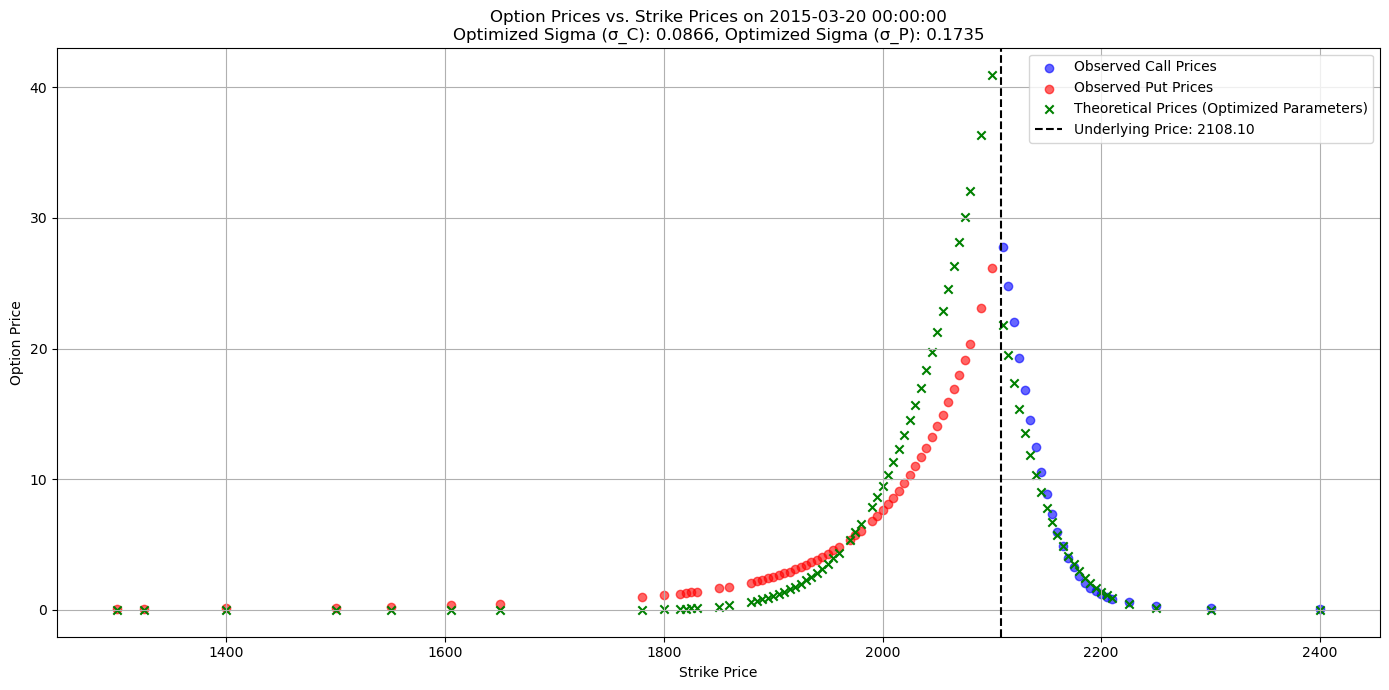

In [5]:
plot_option_prices([underlying['date'].iloc[1]], options, underlying, risk_free_rate)

In [6]:
nworkers =6
result_df = compute_all_dates(options, underlying, risk_free_rate, nworkers)

"Completed 99.95% - {'Date': Timestamp('2023-02-28 00:00:00'), 'Optimized_sigma_C': 0.15440856248688464, 'Optimized_sigma_P': 0.24444668105359185, 'Loss_Error': 67.69277565762188}"

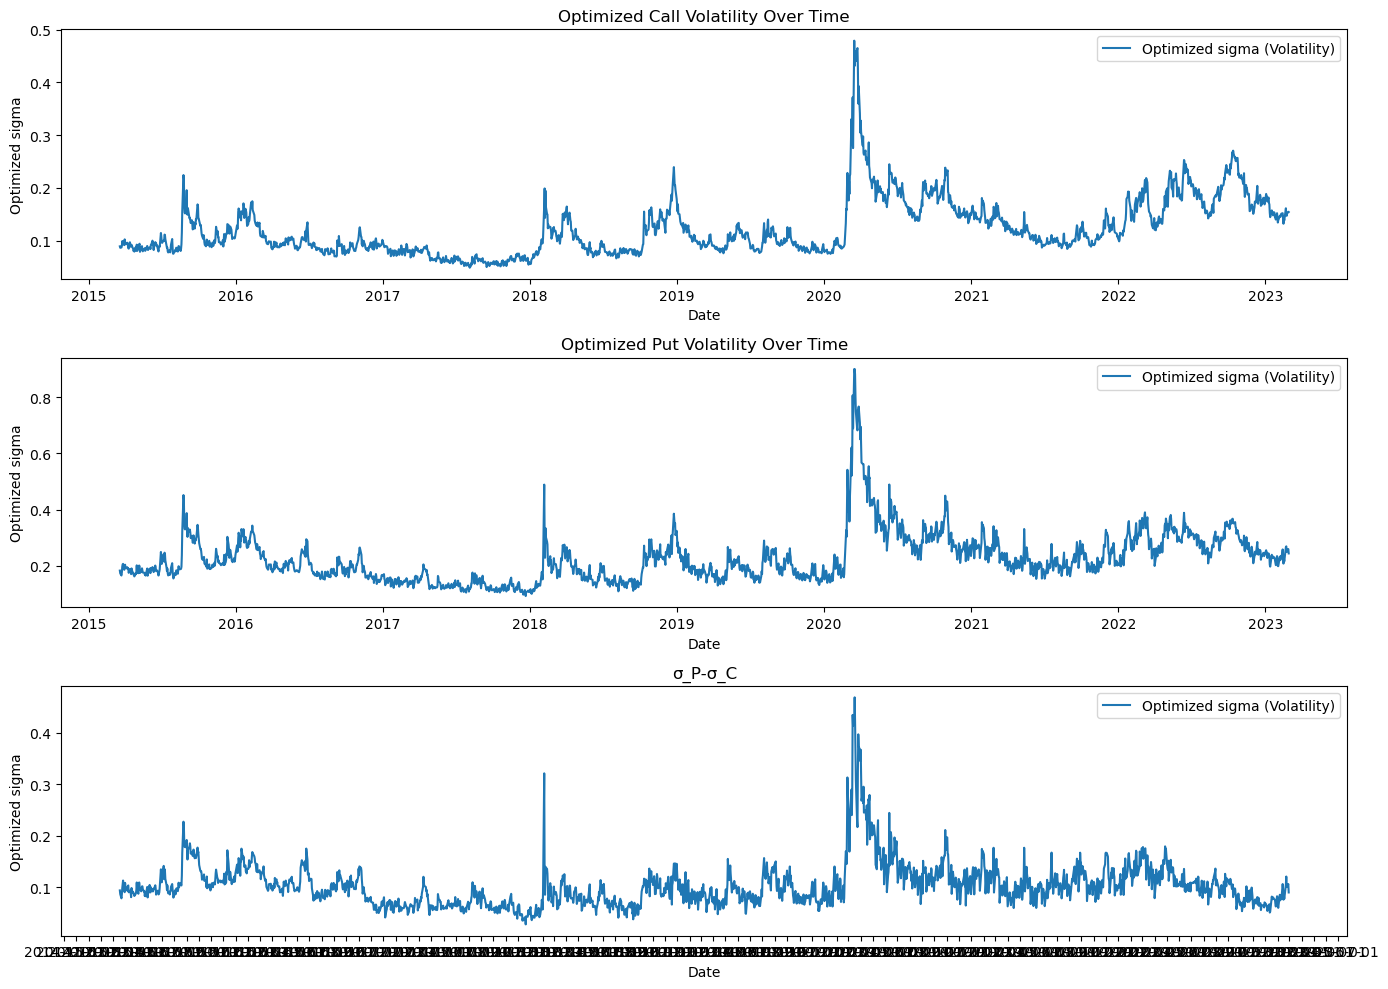

In [7]:
# plot results
plot_results(result_df)

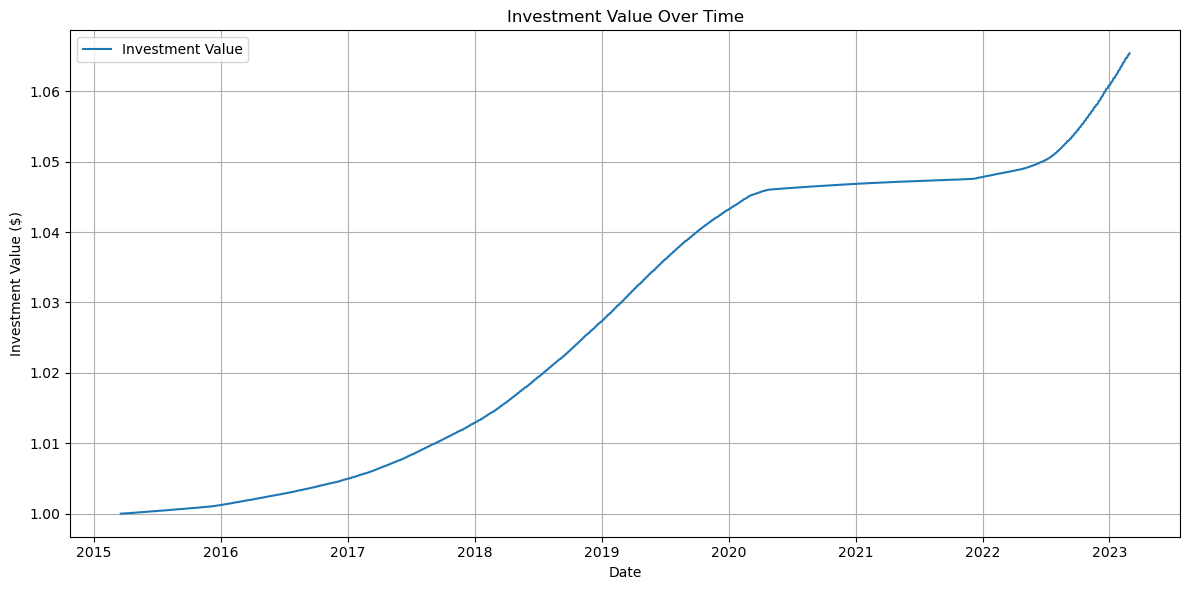

In [8]:
# Initialize a DataFrame to hold the performance results
performance_results = pd.DataFrame(columns=['date', 'investment_value', 'daily_rate'])

# Initialize an investment value
investment_value = 1.0

# Loop through each unique date
unique_dates = risk_free_rate['date'].unique()
for idx, current_date in enumerate(unique_dates):
    # Get the subset of rates for the current date
    rates_subset = risk_free_rate[risk_free_rate['date'] == current_date]
    
    # Check if we have at least two points to interpolate
    if len(rates_subset) < 2:
        print(f"Not enough data points to interpolate for date {current_date}. Skipping.")
        continue
    
    # Create the interpolation function for the current date
    interp_function = interp1d(rates_subset['days'], rates_subset['rate'], kind='linear', fill_value="extrapolate")
    
    # Estimate the 30-day risk-free rate
    rate_30d = float(interp_function(30))
    
    # Convert the annual rate to a daily rate assuming 365 days per year
    daily_rate = (1 + rate_30d/100) ** (1/365) - 1
    
    # Update the investment value
    investment_value *= (1 + daily_rate)
    
    # Store the performance
    performance_results.loc[idx] = [current_date, investment_value, daily_rate]

# Convert 'date' to datetime format for proper plotting
performance_results['date'] = pd.to_datetime(performance_results['date'])


# Set 'date' as the index for plotting
performance_results.set_index('date', inplace=True)

# Plotting the investment value over time
plt.figure(figsize=(12, 6))  # Set the figure size (width, height) in inches
plt.plot(performance_results.index, performance_results['investment_value'], label='Investment Value')
plt.title('Investment Value Over Time')  # Set the title of the plot
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Investment Value ($)')  # Set the y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Turn the grid on
plt.tight_layout()  # Adjust the padding of the plot

# Show the plot
plt.show()

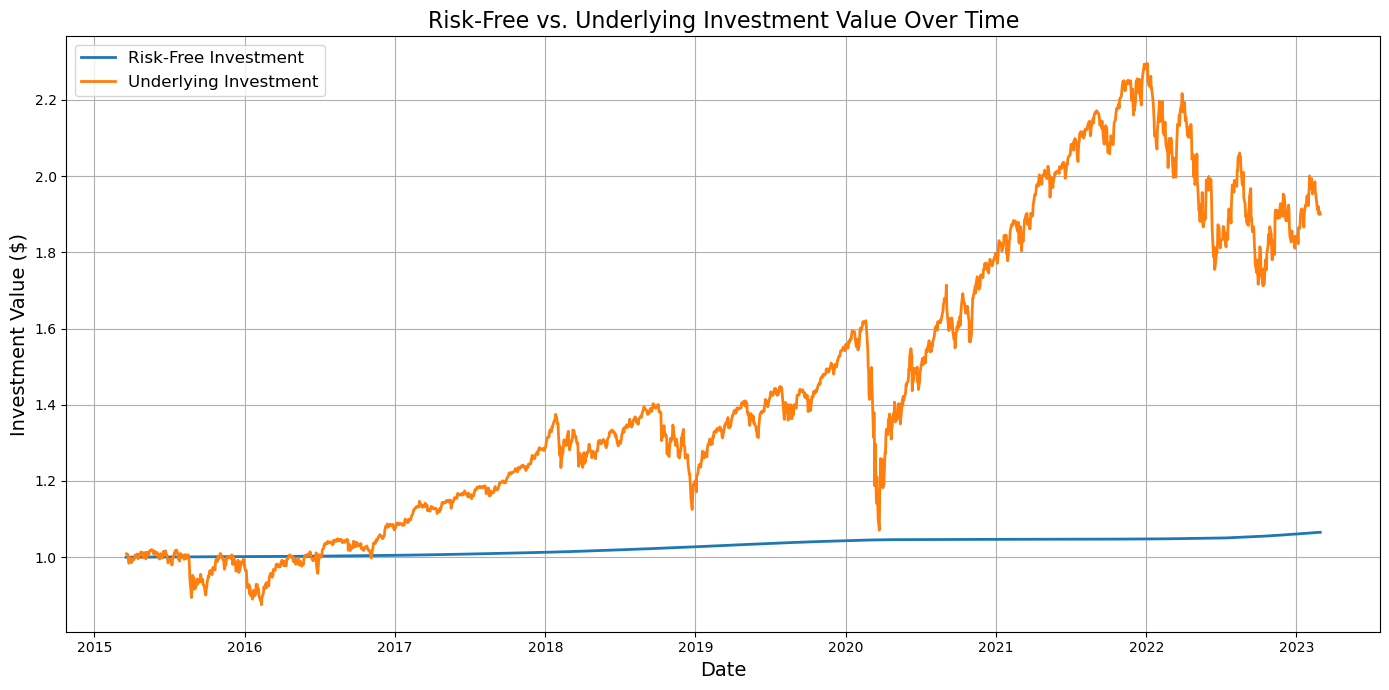

In [9]:
underlying['date'] = pd.to_datetime(underlying['date'])
underlying.sort_values('date', inplace=True)
underlying['daily_return'] = underlying['close'].pct_change()

# Calculate the value of a dollar invested in the underlying, starting with the first day
# We start at 1.0  for the first day, then multiply by (1 + daily_return) each day
underlying['investment_value'] = (1 + underlying['daily_return']).cumprod()

# Plotting both the risk-free investment and the underlying investment on the same graph
plt.figure(figsize=(14, 7))

# Plot the risk-free investment value
plt.plot(performance_results.index, performance_results['investment_value'], label='Risk-Free Investment', linewidth=2)

# Plot the underlying investment value
plt.plot(underlying['date'], underlying['investment_value'], label='Underlying Investment', linewidth=2)

# Title and labels
plt.title('Risk-Free vs. Underlying Investment Value Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Investment Value ($)', fontsize=14)

# Legend
plt.legend(fontsize=12)

# Grid and tight layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Predictive regressions
We are now interested in regressions of the form 
$$\frac{1}{T-t} (R_T - R_{f,t}) = \alpha + \mathbf{\beta} \mathbf{X}_t +\varepsilon_T$$
where $\mathbf{X}_t$ is potentially a scalar or vector of explanatory variables. We first test $\sigma_C$ and $\sigma_P$ separately and then compute the results of including both as explanatory variables. That is we consider three regressions
$$\frac{1}{T-t} (R_T - R_{f,t}) = \alpha + \beta^C \sigma^C_{t,T} +\varepsilon_T$$
$$\frac{1}{T-t} (R_T - R_{f,t}) = \alpha + \beta^P \sigma^P_{t,T} +\varepsilon_T$$
$$\frac{1}{T-t} (R_T - R_{f,t}) = \alpha + \beta^P \sigma^P_{t,T}+ \beta^C \sigma^C_{t,T} +\varepsilon_T$$
where $R_T$ is the realized return from $t$ to $T$, $R_{f,t}$ is the risk-free rate from from $t$ to $T$, $\sigma^C_{t,T}$ is the implied call volatility from $t$ to $T$, and $\sigma^P_{t,T}$ is the implied put volatility from $t$ to $T$. 

In [10]:
# construct excess returns

# Ensure 'date' columns are in datetime format
underlying['date'] = pd.to_datetime(underlying['date'])
risk_free_rate['date'] = pd.to_datetime(risk_free_rate['date'])

# Sort the dataframes by date
underlying.sort_values(by='date', inplace=True)
risk_free_rate.sort_values(by='date', inplace=True)

# Calculate the realized return of the underlying over the past month
trading_days_per_month = 21
underlying['realized_return'] = underlying['close'].pct_change(trading_days_per_month)  # 21 days for approx one month

# Function to fetch the risk-free rate from 30 days prior
def get_risk_free_rate(row):
    date_30_days_prior = row['date'] - pd.DateOffset(days=trading_days_per_month)
    risk_free_row = risk_free_rate[risk_free_rate['date'] <= date_30_days_prior].tail(1)
    return risk_free_row['rate'].values[0]/100 if not risk_free_row.empty else None

# Apply the function to get the risk-free rate for the starting date of the period
underlying['start_of_period_risk_free_rate'] = underlying.apply(get_risk_free_rate, axis=1)

# Calculate the excess return
# need to convert return from annualized to monthly
underlying['excess_return'] = underlying['realized_return'] - ((1+underlying['start_of_period_risk_free_rate'])** (1/12)-1)

# Drop rows where the excess return cannot be calculated (e.g., the first month or missing rates)
underlying.dropna(subset=['excess_return'], inplace=True)

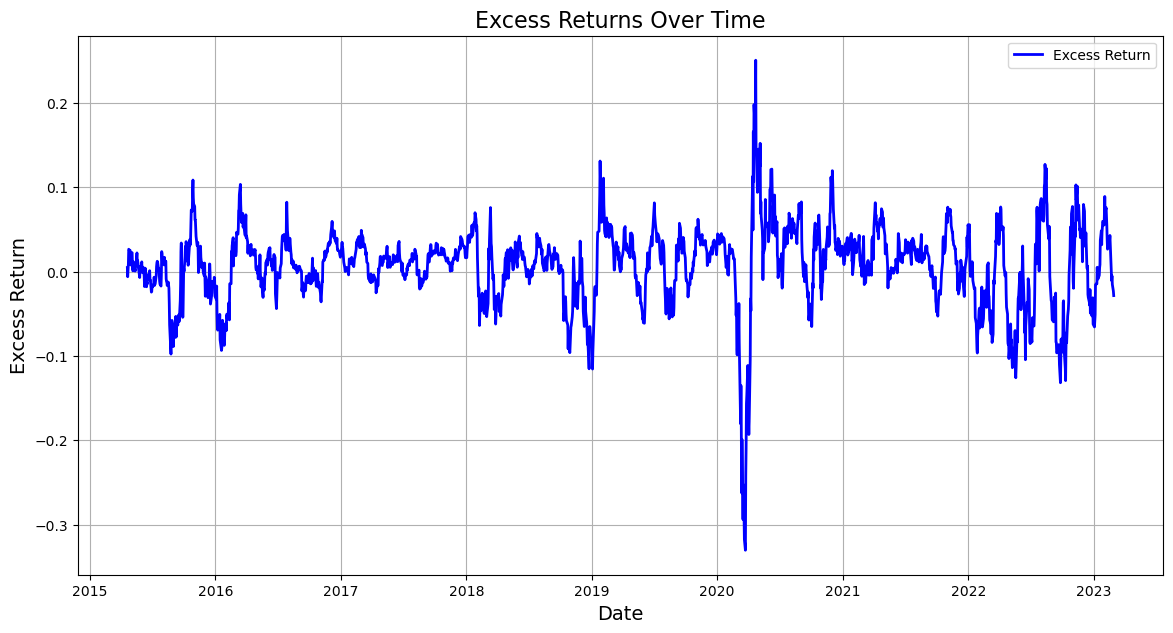

In [11]:
# Plot the excess returns
plt.figure(figsize=(14, 7))  # Set the figure size
plt.plot(underlying['date'], underlying['excess_return'], label='Excess Return', color='blue', linewidth=2)

# Add some labels and a title
plt.title('Excess Returns Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Excess Return', fontsize=14)

# Add a legend
plt.legend()

# Show a grid
plt.grid(True)

# Show the plot
plt.show()

In [12]:
# Assume 'sigma_df' is the other DataFrame containing 'sigma_C' and 'sigma_P' with a 'date' column
result_df['date'] = pd.to_datetime(result_df['Date'])
result_df['diff'] = result_df['Optimized_sigma_C']-result_df['Optimized_sigma_P']

# Calculate forward-looking excess returns
underlying['forward_excess_return'] = underlying['excess_return'].shift(-trading_days_per_month)  # Shift backwards by 30 days

# Create a new DataFrame that will contain the merged data
excess_returns_df = pd.DataFrame()

# Add the date and forward-looking excess returns to the new DataFrame
excess_returns_df['date'] = underlying['date']
excess_returns_df['forward_excess_return'] = underlying['forward_excess_return']
excess_returns_df['forward_realized_return']=underlying['realized_return'].shift(-trading_days_per_month)

# Now merge the new DataFrame with sigma values based on the 'date' column
# We use an 'inner' join to ensure that only the common dates are included
merged_df = pd.merge(excess_returns_df, result_df, on='date', how='inner')

# Drop rows with NaN values that result from shifting (these will be at the end of the DataFrame)
merged_df.dropna(inplace=True)

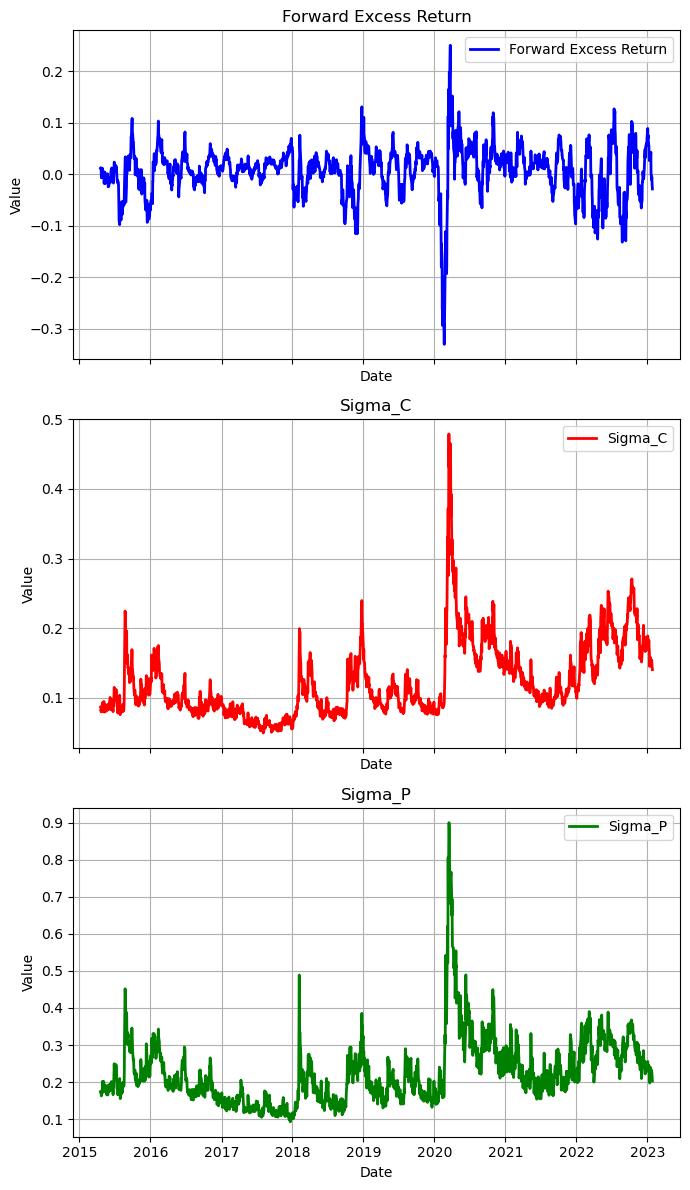

In [13]:
# Set up the figure and the subplots
fig, axs = plt.subplots(3, 1, figsize=(7, 12), sharex=True)  # Sharex=True for sharing the same x-axis

# Plot excess returns
axs[0].plot(merged_df['date'], merged_df['forward_excess_return'], label='Forward Excess Return', color='blue', linewidth=2)
axs[0].set_title('Forward Excess Return')
axs[0].grid(True)

# Plot sigma_C
axs[1].plot(merged_df['date'], merged_df['Optimized_sigma_C'], label='Sigma_C', color='red', linewidth=2)
axs[1].set_title('Sigma_C')
axs[1].grid(True)

# Plot sigma_P
axs[2].plot(merged_df['date'], merged_df['Optimized_sigma_P'], label='Sigma_P', color='green', linewidth=2)
axs[2].set_title('Sigma_P')
axs[2].grid(True)

# Set common labels
for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
merged_df

,date,forward_excess_return,forward_realized_return,Date,Optimized_sigma_C,Optimized_sigma_P,Loss_Error,diff
0,2015-04-20,0.012281,0.013059,2015-04-20,0.086412,0.175004,26.665158,-0.088592
1,2015-04-21,0.012980,0.013618,2015-04-21,0.085031,0.175697,29.182135,-0.090666
2,2015-04-22,0.009905,0.010845,2015-04-22,0.080534,0.168827,20.591820,-0.088293
3,2015-04-23,0.005309,0.006214,2015-04-23,0.082248,0.170023,27.489928,-0.087775
4,2015-04-24,-0.006909,-0.006370,2015-04-24,0.079449,0.162649,37.286342,-0.083200
...,...,...,...,...,...,...,...,...
1953,2023-01-23,-0.010517,-0.007155,2023-01-23,0.153902,0.230864,25.460320,-0.076962
1954,2023-01-24,-0.004942,-0.001153,2023-01-24,0.151434,0.227695,26.417891,-0.076261
1955,2023-01-25,-0.015200,-0.011498,2023-01-25,0.143955,0.219650,9.329532,-0.075695
1956,2023-01-26,-0.022958,-0.019257,2023-01-26,0.143284,0.210792,6.377668,-0.067508


In [15]:

# Add a constant term to the predictors
X1 = sm.add_constant(merged_df['Optimized_sigma_C'])
X2 = sm.add_constant(merged_df['Optimized_sigma_P'])
X3 = sm.add_constant(merged_df[['Optimized_sigma_C', 'Optimized_sigma_P']])
X4 = sm.add_constant(merged_df['diff'])

# Determine the maximum lag for HAC standard errors
max_lag = int((len(X1)**0.25))  # Rule of thumb: T^(1/4)

# Fit the models with robust standard errors
model1 = sm.OLS(merged_df['forward_excess_return'], X1).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})
model2 = sm.OLS(merged_df['forward_excess_return'], X2).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})
model3 = sm.OLS(merged_df['forward_excess_return'], X3).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})
model4 = sm.OLS(merged_df['forward_excess_return'], X4).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})

In [16]:
# Creating a summary DataFrame
summary_data = {
    'Model': [
        'Excess Return ~ sigma_C', 
        'Excess Return ~ sigma_P', 
        'Excess Return ~ sigma_C + sigma_P',
        'Excess Return ~ difference'
    ],
    'Coefficient_sigma_C': [
        model1.params['Optimized_sigma_C'] if 'Optimized_sigma_C' in model1.params else None,
        None,
        model3.params['Optimized_sigma_C'] if 'Optimized_sigma_C' in model3.params else None,
        None
    ],
    'Coefficient_sigma_P': [
        None,
        model2.params['Optimized_sigma_P'] if 'Optimized_sigma_P' in model2.params else None,
        model3.params['Optimized_sigma_P'] if 'Optimized_sigma_P' in model3.params else None,
        None
    ],
    'Coefficient_diff': [
        None,
        None,
        None,
        model4.params['diff'] if 'diff' in model4.params else None
    ],
    't-stat_sigma_C': [
        model1.tvalues['Optimized_sigma_C'] if 'Optimized_sigma_C' in model1.params else None,
        None,
        model3.tvalues['Optimized_sigma_C'] if 'Optimized_sigma_C' in model3.params else None,
        None
    ],
    't-stat_sigma_P': [
        None,
        model2.tvalues['Optimized_sigma_P'] if 'Optimized_sigma_P' in model2.params else None,
        model3.tvalues['Optimized_sigma_P'] if 'Optimized_sigma_P' in model3.params else None,
        None
    ],
    't-stat_diff': [
        None,
        None,
        None,
        model4.tvalues['diff'] if 'diff' in model4.params else None
    ],
    'R-squared': [
        model1.rsquared,
        model2.rsquared,
        model3.rsquared,
        model4.rsquared
    ],
    'R-squared_adj': [  # Added adjusted R-squared for each model
        model1.rsquared_adj,
        model2.rsquared_adj,
        model3.rsquared_adj,
        model4.rsquared_adj
    ]
}

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Replace any missing values with None for a cleaner display
summary_df = summary_df.where(pd.notnull(summary_df), None)

# Display the DataFrame in Jupyter Notebook as an HTML table
summary_df

,Model,Coefficient_sigma_C,Coefficient_sigma_P,Coefficient_diff,t-stat_sigma_C,t-stat_sigma_P,t-stat_diff,R-squared,R-squared_adj
0,Excess Return ~ sigma_C,0.233520,NaN,NaN,4.147315,NaN,NaN,0.069205,0.068729
1,Excess Return ~ sigma_P,NaN,0.140757,NaN,NaN,4.211518,NaN,0.070820,0.070345
2,Excess Return ~ sigma_C + sigma_P,0.099176,0.085302,NaN,0.726464,1.011059,NaN,0.072310,0.071361
3,Excess Return ~ difference,NaN,NaN,-0.244366,NaN,NaN,-3.400767,0.050530,0.050045


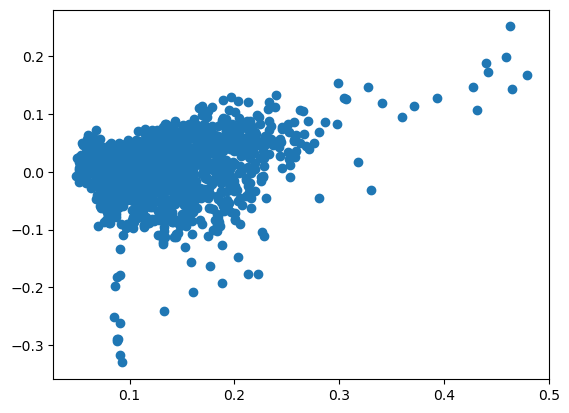

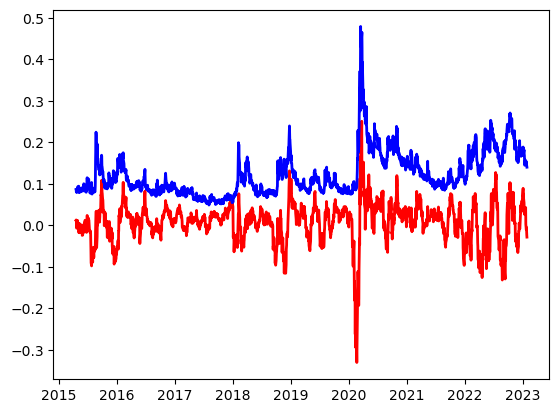

In [17]:
plt.scatter(merged_df['Optimized_sigma_C'], merged_df['forward_realized_return'])
plt.show()
plt.plot(merged_df['date'], merged_df['forward_excess_return'], label='Forward Excess Return', color='red', linewidth=2)
plt.plot(merged_df['date'], merged_df['Optimized_sigma_C'], label='Sigma C', color='blue', linewidth=2)

### Regression results
The R-squared values are high for financial forecasting. We see that higher call volatility corresponds to higher excess returns alone and when included in a regression with put volatilty. Put volatility on the other hand predicts lower excess returns when controlling for call volatility (although this affect is not significant). Standard errors are adjusted heteroscedasticity and autocorrelation to ensure that inference is valid even if certain classical assumptions are violated. 

# Constructing a trading strategy
With high $R^2$ values, we can now see if we can convert that signal into a strategy with a high sharpe ratio. 
We first just create some baseline portfolios

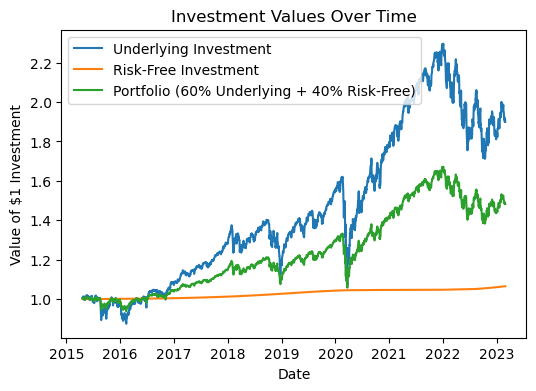

In [18]:
# Reset index on performance_results to make 'date' a column
performance_results_reset = performance_results.reset_index()
w1 = 0.5
w2 = 1- w1
# Now merge with underlying dataframe
combined_investment = pd.merge(
    left=underlying[['date', 'investment_value']],
    right=performance_results_reset[['date', 'investment_value']],
    on='date',
    how='inner',
    suffixes=('_underlying', '_risk_free')
)

combined_investment['portfolio_value'] = (
    w1 * combined_investment['investment_value_underlying'] +
    w2 * combined_investment['investment_value_risk_free']
)


# Create the plot
plt.figure(figsize=(6, 4))

# Plot each of the three series
plt.plot(combined_investment['date'], combined_investment['investment_value_underlying'], label='Underlying Investment')
plt.plot(combined_investment['date'], combined_investment['investment_value_risk_free'], label='Risk-Free Investment')
plt.plot(combined_investment['date'], combined_investment['portfolio_value'], label='Portfolio (60% Underlying + 40% Risk-Free)')

# Adding titles and labels
plt.title('Investment Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value of $1 Investment')
plt.legend()  # Show the legend

# Show the plot
plt.show()

In [19]:
# Calculate daily returns for the portfolio and underlying
combined_investment['portfolio_daily_xr'] = (combined_investment['portfolio_value'].pct_change() - combined_investment['investment_value_risk_free'].pct_change())
combined_investment['underlying_daily_xr'] = (combined_investment['investment_value_underlying'].pct_change()- combined_investment['investment_value_risk_free'].pct_change())

# calculate average excess returns
average_excess_portfolio_return_annualized = combined_investment['portfolio_daily_xr'].mean() * 252
average_excess_underlying_return_annualized = combined_investment['underlying_daily_xr'].mean() * 252


# Calculate the annualized standard deviation of the daily returns
portfolio_return_std_annualized = combined_investment['portfolio_daily_xr'].std() * np.sqrt(252)
underlying_return_std_annualized = combined_investment['underlying_daily_xr'].std() * np.sqrt(252)

# Compute the Sharpe Ratios
sharpe_ratio_portfolio = average_excess_portfolio_return_annualized / portfolio_return_std_annualized
sharpe_ratio_underlying = average_excess_underlying_return_annualized / underlying_return_std_annualized

print(f"Ave. ann. excess return for the split Portfolio: {average_excess_portfolio_return_annualized}")
print(f"Ave. ann. excess return  the Underlying: {average_excess_underlying_return_annualized}")

print(f"Ave. ann. sd for the split Portfolio: {portfolio_return_std_annualized}")
print(f"Ave. ann. sd the Underlying: {underlying_return_std_annualized}")

print(f"Sharpe Ratio for the split Portfolio: {sharpe_ratio_portfolio}")
print(f"Sharpe Ratio for the Underlying: {sharpe_ratio_underlying}")



Ave. ann. excess return for the split Portfolio: 0.04781309747150245
Ave. ann. excess return  the Underlying: 0.09113855498102341
Ave. ann. sd for the split Portfolio: 0.10977997684694102
Ave. ann. sd the Underlying: 0.18986116490090976
Sharpe Ratio for the split Portfolio: 0.43553568551180416
Sharpe Ratio for the Underlying: 0.48002736646322297


### We now create the strategy
Since our measures of volatility predict future returns, we want to use the recent values were low we want to decrease exposure to the risky asset and if the recent values are high we want to increase exposure to the risk asset

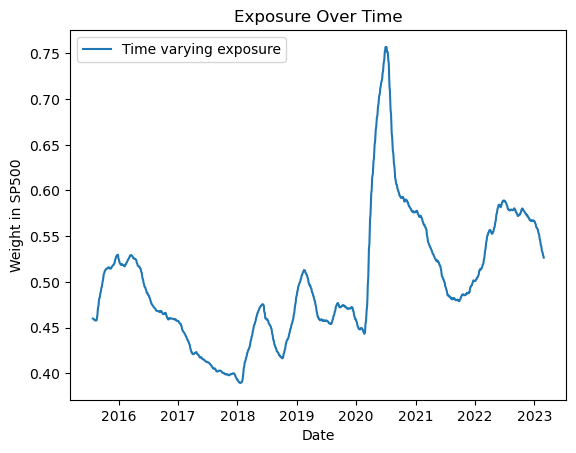

In [59]:
# Normalize sigma_C to get a scaling factor for exposure. The average sigma_C corresponds to 60% exposure.
average_sigma_C = result_df['Optimized_sigma_P'].mean()
result_df['exposure_factor'] = result_df['Optimized_sigma_P'].rolling(window=90).mean() / average_sigma_C

min_exposure, max_exposure = 0.0, 1.0  # 50% to 100% in the underlying
# Adjust the baseline to 0.75 for 75% average exposure to the underlying
# The exposure factor adjusts the exposure around this new average.
# If exposure_factor is 1 (no change), exposure will be 0.75.
# The formula will need to be adjusted if exposure_factor has a different scale or interpretation.
result_df['adjusted_exposure'] = w1 + (result_df['exposure_factor'] - 1) *model1.params['Optimized_sigma_C']
result_df['adjusted_exposure'] = result_df['adjusted_exposure'].clip(min_exposure, max_exposure)

# plot exposure
plt.plot(result_df['date'], result_df['adjusted_exposure'], label='Time varying exposure')


# Adding titles and labels
plt.title('Exposure Over Time')
plt.xlabel('Date')
plt.ylabel('Weight in SP500')
plt.legend()  # Show the legend

# Show the plot
plt.show()

In [68]:
performance_results=performance_results.reset_index()
underlying=underlying.reset_index()

ValueError: cannot insert level_0, already exists

In [61]:
exposure = result_df[['Date','adjusted_exposure']]
exposure['date'] = exposure['Date']
rf_rate = performance_results[['date', 'daily_rate']]
underlying_rate = underlying[['date', 'daily_return']]

/var/folders/9t/gvvpp4nx48x0hnl6jtl7j3s00000gn/T/ipykernel_320/342882382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposure['date'] = exposure['Date']


In [62]:
exposure

,Date,adjusted_exposure,date
2,2015-03-19,NaN,2015-03-19
1,2015-03-20,NaN,2015-03-20
3,2015-03-23,NaN,2015-03-23
5,2015-03-24,NaN,2015-03-24
4,2015-03-25,NaN,2015-03-25
...,...,...,...
1997,2023-02-22,0.531093,2023-02-22
1993,2023-02-23,0.529921,2023-02-23
1996,2023-02-24,0.528813,2023-02-24
1998,2023-02-27,0.527724,2023-02-27


In [63]:
merged_df = pd.merge(exposure, rf_rate, on='date', how='inner')
dynamic_strat_df = pd.merge(merged_df, underlying_rate, on='date', how='inner')
dynamic_strat_df = dynamic_strat_df.rename(columns={
    'daily_rate': 'rf',
    'daily_return': 'risky_return',
    # Add as many columns as you want to rename
})

In [64]:
dynamic_strat_df['weighted_return'] = dynamic_strat_df['adjusted_exposure'] * dynamic_strat_df['risky_return'] + (1-dynamic_strat_df['adjusted_exposure'])*dynamic_strat_df['rf']
dynamic_strat_df['static_return'] = w1 * dynamic_strat_df['risky_return'] + w2*dynamic_strat_df['rf']

In [65]:
dynamic_strat_df['strategy_value'] = (1 + dynamic_strat_df['weighted_return']).cumprod()
dynamic_strat_df['rf_value'] = (1 + dynamic_strat_df['rf']).cumprod()
dynamic_strat_df['risky_value'] = (1 + dynamic_strat_df['risky_return']).cumprod()
dynamic_strat_df['static_value'] = (1 + dynamic_strat_df['static_return']).cumprod()

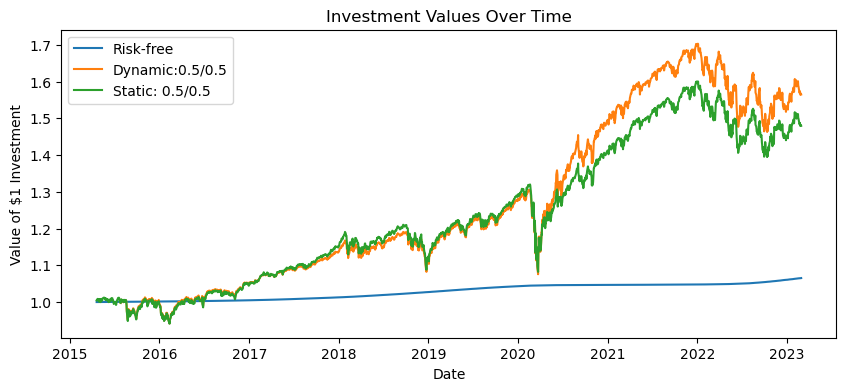

In [66]:
# Create the plot
plt.figure(figsize=(10, 4))

# Plot each of the three series
plt.plot(dynamic_strat_df['date'], dynamic_strat_df['rf_value'], label='Risk-free')
plt.plot(dynamic_strat_df['date'], dynamic_strat_df['strategy_value'], label=f'Dynamic:{w1}/{w2}')
#plt.plot(dynamic_strat_df['date'], dynamic_strat_df['risky_value'], label='SP500')
plt.plot(dynamic_strat_df['date'], dynamic_strat_df['static_value'], label=f"Static: {w1}/{w2}")


# Adding titles and labels
plt.title('Investment Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value of $1 Investment')
plt.legend()  # Show the legend

# Show the plot
plt.show()


In [67]:
# calculate average excess returns
xr_strat = (dynamic_strat_df['weighted_return']-dynamic_strat_df['rf']).mean() * 252
xr_risky = (dynamic_strat_df['risky_return']-dynamic_strat_df['rf']).mean() * 252
xr_static = (dynamic_strat_df['static_return']-dynamic_strat_df['rf']).mean() * 252


# Calculate the annualized standard deviation of the daily returns
strat_std = (dynamic_strat_df['weighted_return']-dynamic_strat_df['rf']).std() * np.sqrt(252)
risky_std = (dynamic_strat_df['risky_return']-dynamic_strat_df['rf']).std() * np.sqrt(252)
static_std = (dynamic_strat_df['static_return']-dynamic_strat_df['rf']).std() * np.sqrt(252)

# Compute the Sharpe Ratios
sharpe_ratio_strat = xr_strat / strat_std
sharpe_ratio_risky= xr_risky / risky_std
sharpe_ratio_static= xr_static / static_std


print(f"Ave. ann. excess return  the underlying: {xr_risky}")
print(f"Ave. ann. excess return  the static portfolio: {xr_static}")
print(f"Ave. ann. excess return for the strategy: {xr_strat}")


print(f"Ave. ann. sd for the underlying: {risky_std}")
print(f"Ave. ann. sd the static portfolio: {static_std}")
print(f"Ave. ann. sd the strategy: {strat_std}")

print(f"Sharpe Ratio for the underlying : {sharpe_ratio_risky}")
print(f"Sharpe Ratio for the static portfolio : {sharpe_ratio_static}")
print(f"Sharpe Ratio for the strategy: {sharpe_ratio_strat}")

Ave. ann. excess return  the underlying: 0.0927474317583203
Ave. ann. excess return  the static portfolio: 0.04637371587916015
Ave. ann. excess return for the strategy: 0.05599555808835853
Ave. ann. sd for the underlying: 0.1898827653021518
Ave. ann. sd the static portfolio: 0.0949413826510759
Ave. ann. sd the strategy: 0.10209266703848954
Sharpe Ratio for the underlying : 0.4884457607868493
Sharpe Ratio for the static portfolio : 0.4884457607868493
Sharpe Ratio for the strategy: 0.5484777674311111
